Notebook for testing the loader 

In [43]:
### importing all the modules created to load and preprocess the data with pooling ###
import os
import sys
# This allows importing from parent directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
sys.path.insert(0, project_root)

import importlib
from ETL_scripts import loader
importlib.reload(loader) # reload to get the latest version
from ETL_scripts.loader import WRDSLoader

from ETL_scripts import preprocessor
importlib.reload(preprocessor)
from ETL_scripts.preprocessor import DataPreprocessor

from utils import connection_pool
importlib.reload(connection_pool) 
from utils.connection_pool import ConnectionPool

from config import loader_config
importlib.reload(loader_config)
from config.loader_config import LoaderConfig



In [44]:
### Libraries for EDA ###
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set plot style using seaborn
sns.set_style("darkgrid")  # or try "whitegrid", "dark", "white", "ticks"

In [45]:
### setting up the connection pool ###
pool = ConnectionPool(username='xxx')

In [46]:
### used to explore the connection between the compustat and the crsp data ###
with pool.connection() as loader:
    # Explore the CCM linking table
    link_query = """
    SELECT table_name 
    FROM information_schema.tables
    WHERE table_schema = 'crsp_a_ccm'
    """
    link_tables = loader.db.raw_sql(link_query)
    print("CRSP-Compustat Merged tables:", link_tables['table_name'].tolist())
    
    # Check ccmxpf_linktable structure
    link_columns_query = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'crsp_a_ccm' AND table_name = 'ccmxpf_linktable'
    """
    link_columns = loader.db.raw_sql(link_columns_query)
    print("\nCCM link table columns:", link_columns['column_name'].tolist())

Loading library list...
Done
CRSP-Compustat Merged tables: ['ccm_lookup', 'ccm_qvards', 'ccmxpf_linktable', 'ccmxpf_lnkhist', 'ccmxpf_lnkrng', 'ccmxpf_lnkused', 'comphead', 'comphist', 'compmaster', 'cst_hist', 'sechead', 'sechist']

CCM link table columns: ['gvkey', 'linkprim', 'liid', 'linktype', 'lpermno', 'lpermco', 'usedflag', 'linkdt', 'linkenddt']


In [47]:
### Importing the data (on stocks, fundamentals, and Fama French factors) ###

import time

print("Initializing loader...")
start_time = time.time()
with pool.connection() as loader:
    print(f"Loader initialized in {time.time() - start_time:.2f} seconds")

    print("\nFetching stock data...")
    query_start = time.time()
    stocks = loader.get_monthly_stock_data(
        tickers=LoaderConfig.get_ticker_group('sp500_ex_financials'),
        start_date=LoaderConfig.get_date_range('full_period')['start'],
        end_date=LoaderConfig.get_date_range('full_period')['end'],
        )
    
    print("\nFetching fundamentals data...")
    fundamentals = loader.get_fundamental_data(
        tickers=LoaderConfig.get_ticker_group('sp500_ex_financials'),
        start_date=LoaderConfig.get_date_range('full_period')['start'],
        end_date=LoaderConfig.get_date_range('full_period')['end'],
        )
    
    print("\nFetching Fama French data...") 
    fama_french = loader.get_fama_french_factors(
        start_date=LoaderConfig.get_date_range('full_period')['start'],
        end_date=LoaderConfig.get_date_range('full_period')['end'],
        frequency='monthly',
        model='five_factor'
        )

    # df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    print(f"Data fetched in {time.time() - query_start:.2f} seconds")

    # Look at the data
    # print("\nData summary:")
    # print("Data shape:", df.shape)
    # print("\nFirst few rows:")
    # print(df[['date', 'ticker', 'price_adjusted', 'volume_adjusted', 'market_cap', 'cum_ret']].head())


Initializing loader...
Loader initialized in 0.08 seconds

Fetching stock data...

Fetching fundamentals data...

Fetching Fama French data...
Data fetched in 13.76 seconds


In [48]:
import time

print("Initializing loader...")
start_time = time.time()
with pool.connection() as loader:
    print(f"Loader initialized in {time.time() - start_time:.2f} seconds")

    print("\nFetching macro data...")
    query_start = time.time()
    macro = loader.get_macro_factors(
        start_date=LoaderConfig.get_date_range('full_period')['start'],
        end_date=LoaderConfig.get_date_range('full_period')['end'],
        )

    # df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    print(f"Data fetched in {time.time() - query_start:.2f} seconds")


Initializing loader...
Loader initialized in 0.00 seconds

Fetching macro data...
Successfully retrieved interest rates: 240 rows
Successfully retrieved economic indicators: 240 rows
Final macro data has 240 rows and columns: ['date', 'tb3m_rate', 'tb10y_rate', 'fed_funds_rate', 'tb1y_rate', 'gs2_rate', 'aaa_rate', 'baa_rate', 'term_spread', 'credit_spread', 'gdp_monthly', 'gdp_quarterly', 'cpi', 'unemployment_rate', 'gdp_growth_yoy', 'gdp_growth_qoq', 'inflation_yoy', 'unemployment_change', 'year_month']
Data fetched in 0.42 seconds


In [49]:
stocks['date'] = pd.to_datetime(stocks['date'], format='%Y-%m-%d')
fama_french['date'] = pd.to_datetime(fama_french['date'], format='%Y-%m-%d')
fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'], format='%Y-%m-%d')

In [50]:
stocks.sort_values(by=['ticker', 'date'], inplace=True)
print(stocks.shape)
print(stocks.head())

(91612, 11)
      permno       date ticker    prc  price_unadj       ret      retx  \
222    87432 2005-01-31      A  22.11        22.11 -0.082573 -0.082573   
589    87432 2005-02-28      A   24.0         24.0  0.085482  0.085482   
890    87432 2005-03-31      A   22.2         22.2    -0.075    -0.075   
1283   87432 2005-04-29      A  20.75        20.75 -0.065315 -0.065315   
1615   87432 2005-05-31      A  24.01        24.01  0.157108  0.157108   

           vol    shrout  price_adjustment_factor  shares_adjustment_factor  
222   504683.0  491098.0                 1.464715                       1.0  
589   513677.0  491000.0                 1.464715                       1.0  
890   557250.0  491164.0                 1.464715                       1.0  
1283  545919.0  491164.0                 1.464715                       1.0  
1615  482805.0  491000.0                 1.464715                       1.0  


In [51]:
# Example usage:
incomplete = DataPreprocessor.check_wrds_coverage(stocks, '2010-01-01', '2024-12-31')
DataPreprocessor.print_coverage_summary(incomplete, '2010-01-01', '2024-12-31')

/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expected_dates = pd.date_range(start=start_date,



Found 77 tickers with incomplete date range coverage:
Expected date range: 2010-01 to 2024-12

Ticker: SW
Actual period: 2024-07 to 2024-12
Missing 174 months at the beginning
Coverage: 3.33%

Ticker: GEV
Actual period: 2024-04 to 2024-12
Missing 171 months at the beginning
Coverage: 5.00%

Ticker: SOLV
Actual period: 2024-04 to 2024-12
Missing 171 months at the beginning
Coverage: 5.00%

Ticker: DAY
Actual period: 2024-02 to 2024-12
Missing 169 months at the beginning
Coverage: 6.11%

Ticker: VLTO
Actual period: 2023-10 to 2024-12
Missing 165 months at the beginning
Coverage: 8.33%

Ticker: KVUE
Actual period: 2023-05 to 2024-12
Missing 160 months at the beginning
Coverage: 11.11%

Ticker: GEHC
Actual period: 2023-01 to 2024-12
Missing 156 months at the beginning
Coverage: 13.33%

Ticker: FXLV
Actual period: 2021-07 to 2023-07
Missing 138 months at the beginning
Missing 17 months at the end
Coverage: 13.89%

Ticker: BALL
Actual period: 2022-05 to 2024-12
Missing 148 months at the beg

In [53]:
filtered_stocks = DataPreprocessor.filter_complete_data(stocks, incomplete, '2010-01-01', '2024-12-31')
print(filtered_stocks.shape)
print(filtered_stocks.head())
print(filtered_stocks.isnull().sum())

Filtering out 77 tickers with incomplete coverage (17.78% of 433 total tickers)
Remaining tickers: 356
Rows in original DataFrame: 91,612
Rows in filtered DataFrame: 83,285
Removed 8,327 rows (9.09% of data)
(83285, 11)
      permno       date ticker    prc  price_unadj       ret      retx  \
222    87432 2005-01-31      A  22.11        22.11 -0.082573 -0.082573   
589    87432 2005-02-28      A   24.0         24.0  0.085482  0.085482   
890    87432 2005-03-31      A   22.2         22.2    -0.075    -0.075   
1283   87432 2005-04-29      A  20.75        20.75 -0.065315 -0.065315   
1615   87432 2005-05-31      A  24.01        24.01  0.157108  0.157108   

           vol    shrout  price_adjustment_factor  shares_adjustment_factor  
222   504683.0  491098.0                 1.464715                       1.0  
589   513677.0  491000.0                 1.464715                       1.0  
890   557250.0  491164.0                 1.464715                       1.0  
1283  545919.0  491164.

In [54]:
# Count rows per ticker
ticker_col = 'ticker' if 'ticker' in filtered_stocks.columns else 'permno'
ticker_counts = filtered_stocks[ticker_col].value_counts()

# View the counts
print(ticker_counts)

ticker
LEN     480
MKC     480
TAP     478
STZ     454
NWS     287
       ... 
ELV     102
AMCR     96
TPR      93
CTRA     79
TT       65
Name: count, Length: 356, dtype: Int64


In [55]:
def plot_ticker(df, ticker_symbol, value_column='prc', title=None):
    """
    Plot a time series of data for a specific ticker.
    
    Parameters:
    df: DataFrame with 'date', ticker column, and value column
    ticker_symbol: The ticker to plot
    value_column: Column name containing the values to plot (default: 'return')
    title: Custom title for the plot (default: auto-generated)
    
    Returns:
    matplotlib.axes.Axes: The plot axes for further customization if needed
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    # Identify ticker column
    ticker_col = 'ticker' if 'ticker' in df.columns else 'permno'
    
    # Filter data for the specified ticker
    ticker_data = df[df[ticker_col] == ticker_symbol].copy()
    
    # Sort by date
    ticker_data = ticker_data.sort_values('date')
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the data
    ax.plot(ticker_data['date'], ticker_data[value_column], linewidth=2)
    
    # Set title
    if title is None:
        title = f"{ticker_symbol} - {value_column} over time"
    ax.set_title(title, fontsize=14)
    
    # Format x-axis as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add labels
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(value_column.capitalize(), fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add ticker info
    first_date = ticker_data['date'].min().strftime('%Y-%m-%d')
    last_date = ticker_data['date'].max().strftime('%Y-%m-%d')
    data_points = len(ticker_data)
    
    info_text = f"Data range: {first_date} to {last_date}\nTotal data points: {data_points}"
    plt.figtext(0.02, 0.02, info_text, fontsize=10)
    
    # Tight layout
    plt.tight_layout()
    
    return ax

In [56]:
# Filter for tickers with exactly 240 observations
filtered_df, excluded_tickers = DataPreprocessor.filter_by_observation_count(
    filtered_stocks, 
    start_date='2005-01-01', 
    end_date='2024-12-31', 
    expected_count=240
)

# If you want to see which tickers had specific counts
print("\nSome examples of excluded tickers:")
for ticker, count in list(excluded_tickers.items())[:10]:  # First 10 excluded tickers
    print(f"Ticker {ticker}: {count} observations (expected 240)")

Date range: 2005-01-01 to 2024-12-31
Expected observations per ticker: 240
Total tickers: 356
Tickers with exact 240 observations: 291 (81.74%)
Excluded tickers: 65 (18.26%)
Original row count: 83285
Filtered row count: 69840

Distribution of observation counts:
65 observations: 1 tickers
79 observations: 1 tickers
93 observations: 1 tickers
96 observations: 1 tickers
102 observations: 1 tickers
105 observations: 1 tickers
109 observations: 1 tickers
113 observations: 1 tickers
117 observations: 1 tickers
121 observations: 1 tickers
134 observations: 1 tickers
140 observations: 1 tickers
155 observations: 1 tickers
160 observations: 1 tickers
166 observations: 1 tickers
168 observations: 1 tickers
173 observations: 1 tickers
178 observations: 2 tickers
182 observations: 1 tickers
183 observations: 1 tickers
185 observations: 3 tickers
188 observations: 1 tickers
193 observations: 1 tickers
195 observations: 1 tickers
197 observations: 1 tickers
201 observations: 1 tickers
202 observati

In [57]:
import pandas as pd

# First, let's create a dictionary that maps each ticker to its industry
ticker_to_industry = {}

# Import the TICKERS dictionary from your config file
from config.loader_config import TICKERS_IND

# Populate the mapping dictionary
for industry, tickers in TICKERS_IND.items():
    for ticker in tickers:
        ticker_to_industry[ticker] = industry

# Now add the industry as a new column to your DataFrame
filtered_df['industry'] = filtered_df['ticker'].map(ticker_to_industry)

# Check for any tickers that might not have matched
missing_industry = filtered_df[filtered_df['industry'].isna()]
if len(missing_industry) > 0:
    print(f"Warning: {len(missing_industry)} tickers don't have an industry assigned.")
    print("First few missing tickers:", missing_industry['ticker'].head().tolist())

# To display industries for each ticker in the new DataFrame
unique_tickers = filtered_df['ticker'].unique()

# Option 1: Print each ticker with its industry
for ticker in unique_tickers:
    # Get the industry for this ticker
    ticker_data = filtered_df[filtered_df['ticker'] == ticker][['ticker', 'industry']].iloc[0]
    print(f"Ticker: {ticker_data['ticker']}, Industry: {ticker_data['industry']}")

Ticker: A, Industry: Industrials
Ticker: AAPL, Industry: Information Technology
Ticker: ABT, Industry: Health Care
Ticker: ACN, Industry: Information Technology
Ticker: ADBE, Industry: Information Technology
Ticker: ADI, Industry: Information Technology
Ticker: ADM, Industry: Consumer Staples
Ticker: ADP, Industry: Information Technology
Ticker: ADSK, Industry: Information Technology
Ticker: AEE, Industry: Utilities
Ticker: AEP, Industry: Utilities
Ticker: AES, Industry: Utilities
Ticker: AKAM, Industry: Information Technology
Ticker: ALB, Industry: Materials
Ticker: ALGN, Industry: Health Care
Ticker: AMAT, Industry: Information Technology
Ticker: AMD, Industry: Information Technology
Ticker: AME, Industry: Industrials
Ticker: AMGN, Industry: Health Care
Ticker: AMT, Industry: Real Estate
Ticker: AMZN, Industry: Consumer Discretionary
Ticker: ANSS, Industry: Information Technology
Ticker: AOS, Industry: Industrials
Ticker: APA, Industry: Energy
Ticker: APD, Industry: Materials
Ticker:

In [58]:
print(fama_french.shape)
print(fama_french.columns.tolist())
print(fama_french.head())


(240, 8)
['date', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd']
        date   mktrf     smb     hml     rmw     cma      rf     umd
0 2005-01-01 -0.0276 -0.0117  0.0206  0.0274 -0.0146  0.0016  0.0305
1 2005-02-01  0.0189 -0.0031  0.0154  0.0143 -0.0005  0.0016  0.0337
2 2005-03-01 -0.0197 -0.0142  0.0204  0.0046  0.0129  0.0021  0.0041
3 2005-04-01 -0.0261 -0.0398  0.0007  0.0097 -0.0094  0.0021 -0.0069
4 2005-05-01  0.0365  0.0278 -0.0064   -0.01   0.003  0.0024  0.0045


In [59]:
def check_na_by_ticker(df, unique_tickers, fields=None):
    """
    Check NA values for each ticker in the unique_tickers list.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with fundamental data
    unique_tickers : list
        List of tickers to analyze
    fields : list, optional
        List of specific fields to check for NAs. If None, checks all columns.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with NA counts and percentages by ticker
    """
    # Create a results DataFrame
    results = pd.DataFrame(index=unique_tickers)
    
    # Initialize results columns
    results['total_rows'] = 0
    results['na_count'] = 0
    results['na_pct'] = 0.0
    
    # Determine which fields to check
    if fields is None:
        # Exclude metadata columns
        metadata_cols = ['gvkey', 'datadate', 'ticker', 'fyearq']
        fields = [col for col in df.columns if col not in metadata_cols]
    
    # Loop through each ticker
    for ticker in unique_tickers:
        # Get data for this ticker
        ticker_data = df[df['ticker'] == ticker]
        
        if not ticker_data.empty:
            # Count total rows and total possible data points
            total_rows = ticker_data.shape[0]
            total_cells = total_rows * len(fields)
            
            # Count NA values across all specified fields
            na_count = ticker_data[fields].isna().sum().sum()
            
            # Calculate NA percentage
            na_pct = (na_count / total_cells) * 100 if total_cells > 0 else 0
            
            # Store results
            results.loc[ticker, 'total_rows'] = total_rows
            results.loc[ticker, 'na_count'] = na_count
            results.loc[ticker, 'na_pct'] = round(na_pct, 2)
        else:
            # Ticker not found in data
            results.loc[ticker, 'total_rows'] = 0
            results.loc[ticker, 'na_count'] = 0
            results.loc[ticker, 'na_pct'] = 0
    
    # Sort by NA percentage (descending)
    results = results.sort_values('na_pct', ascending=False)
    
    return results

# Example usage:
na_analysis = check_na_by_ticker(fundamentals, unique_tickers)
print(na_analysis.head(20))  # Display top 20 tickers with most NAs
# 
# # For specific fields only
# key_fields = ['atq', 'ltq', 'seqq', 'ibq', 'revtq', 'niq', 'oiadpq', 'prccq']
# key_fields_na = check_na_by_ticker(fundamental_df, unique_tickers, fields=key_fields)
# print(key_fields_na.head(20))

      total_rows  na_count  na_pct
PLD          105       441   16.80
EXR           80       335   16.75
REG           80       319   15.95
PSA           80       313   15.65
FRT           80       308   15.40
AVB           80       305   15.25
MAA           80       305   15.25
DLR           80       304   15.20
CPT           80       303   15.15
KIM           80       300   15.00
ESS           80       299   14.95
ARE           80       295   14.75
BXP           80       294   14.70
VTR           80       292   14.60
SPG           90       322   14.31
EQR           80       281   14.05
TPL           80       225   11.25
UDR           80       213   10.65
DE            80       208   10.40
PCAR          80       199    9.95


In [60]:
fundamentals_clean = DataPreprocessor.clean_with_gvkey_strategy(fundamentals, strategy='most_data')
na_analysis1 = check_na_by_ticker(fundamentals_clean, unique_tickers)

print(na_analysis1.sort_values('total_rows', ascending=False).head(20))

Rows before cleaning: 33433
Rows after cleaning: 31641
Removed 1792 duplicate ticker-quarter observations
Strategy used: most_data
      total_rows  na_count  na_pct
ZBRA          80         0    0.00
EXR           80       335   16.75
PLD           80       330   16.50
ROK           80         0    0.00
PNW           80         0    0.00
PPL           80         0    0.00
PH            80         0    0.00
CE            80         0    0.00
CHD           80         0    0.00
KMX           80         0    0.00
MTD           80         0    0.00
NKE           80         0    0.00
NSC           80         0    0.00
MU            80         0    0.00
NI            80         0    0.00
BG            80         0    0.00
ORLY          80         0    0.00
OMC           80         0    0.00
CCL           80         0    0.00
ISRG          80        91    4.55


In [61]:

missing_by_ticker, missing_by_field, tickers_to_exclude, fields_to_exclude = DataPreprocessor.analyze_missing_fundamentals(fundamentals_clean, unique_tickers)
DataPreprocessor.visualize_missing_data(missing_by_ticker, missing_by_field)
# coverage_df = DataPreprocessor.analyze_time_coverage(fundamentals_clean)

# Print recommendations
print("\nRecommended tickers to exclude due to missing data:")
print(tickers_to_exclude)
print("\nRecommended fields to exclude due to missing data:")
print(fields_to_exclude)
print("\nTime coverage analysis (first 10 rows):")
# print(coverage_df.head(10))

# You can also save the analysis results for further use
# missing_by_ticker.to_csv('missing_by_ticker.csv')
# missing_by_field.to_csv('missing_by_field.csv')
# coverage_df.to_csv('time_coverage_by_ticker.csv')

Total unique tickers in analysis: 291
Tickers found in fundamental data: 290

['ETN']

Recommended tickers to exclude due to missing data:
['EXR', 'PLD', 'REG', 'PSA', 'FRT', 'AVB', 'MAA', 'DLR', 'CPT', 'KIM', 'ESS', 'ARE', 'BXP', 'VTR', 'SPG', 'EQR', 'TPL', 'UDR', 'DE', 'PCAR', 'NVR']

Recommended fields to exclude due to missing data:
['txpq']

Time coverage analysis (first 10 rows):


In [62]:
fundamentalsdf = DataPreprocessor.filter_dataframe_by_tickers(fundamentals_clean, unique_tickers)
print(fundamentalsdf.shape)
print(fundamentalsdf.head())
# Check for missing values
print(fundamentalsdf.isnull().sum())

Original DataFrame shape: (31641, 29)
Filtered DataFrame shape: (23156, 29)
Kept 290 unique tickers out of 291 requested
['ETN']
(23156, 29)
    gvkey   datadate ticker  permno  fyearq     atq     ltq    seqq    ibq  \
0  126554 2005-01-31      A   87432    2005  7150.0  3382.0  3768.0   51.0   
1  126554 2005-04-30      A   87432    2005  7268.0  3399.0  3869.0   53.0   
2  126554 2005-07-31      A   87432    2005  7352.0  3404.0  3948.0   54.0   
3  126554 2005-10-31      A   87432    2005  6751.0  2636.0  4081.0  -17.0   
4  126554 2006-01-31      A   87432    2006  8026.0  3844.0  4182.0  974.0   

   cshoq  ...  prccq  dvpsxq    actq    lctq   txpq   txtq   dpq   invtq  \
0  491.0  ...  22.11     0.0  4649.0  1771.0  351.0   15.0  48.0  1037.0   
1  491.0  ...  20.75     0.0  4813.0  1765.0  351.0   19.0  44.0   958.0   
2  494.0  ...  26.24     0.0  4926.0  1771.0  374.0   19.0  49.0   936.0   
3  503.0  ...  32.01     0.0  4447.0  1936.0  474.0  102.0  45.0   722.0   
4  430.0  

Top 10 tickers with most missing liquidity data:
      actq   lctq   dlcq  overall_missing_pct
FRT  100.0  100.0  85.00            95.000000
AVB  100.0  100.0  81.25            93.750000
DLR  100.0  100.0  80.00            93.333333
CPT  100.0  100.0  78.75            92.916667
REG  100.0  100.0  75.00            91.666667
KIM  100.0  100.0  75.00            91.666667
ESS  100.0  100.0  73.75            91.250000
MAA  100.0  100.0  72.50            90.833333
PSA  100.0  100.0  71.25            90.416667
PLD  100.0  100.0  68.75            89.583333

25 tickers have >50% missing values in liquidity columns


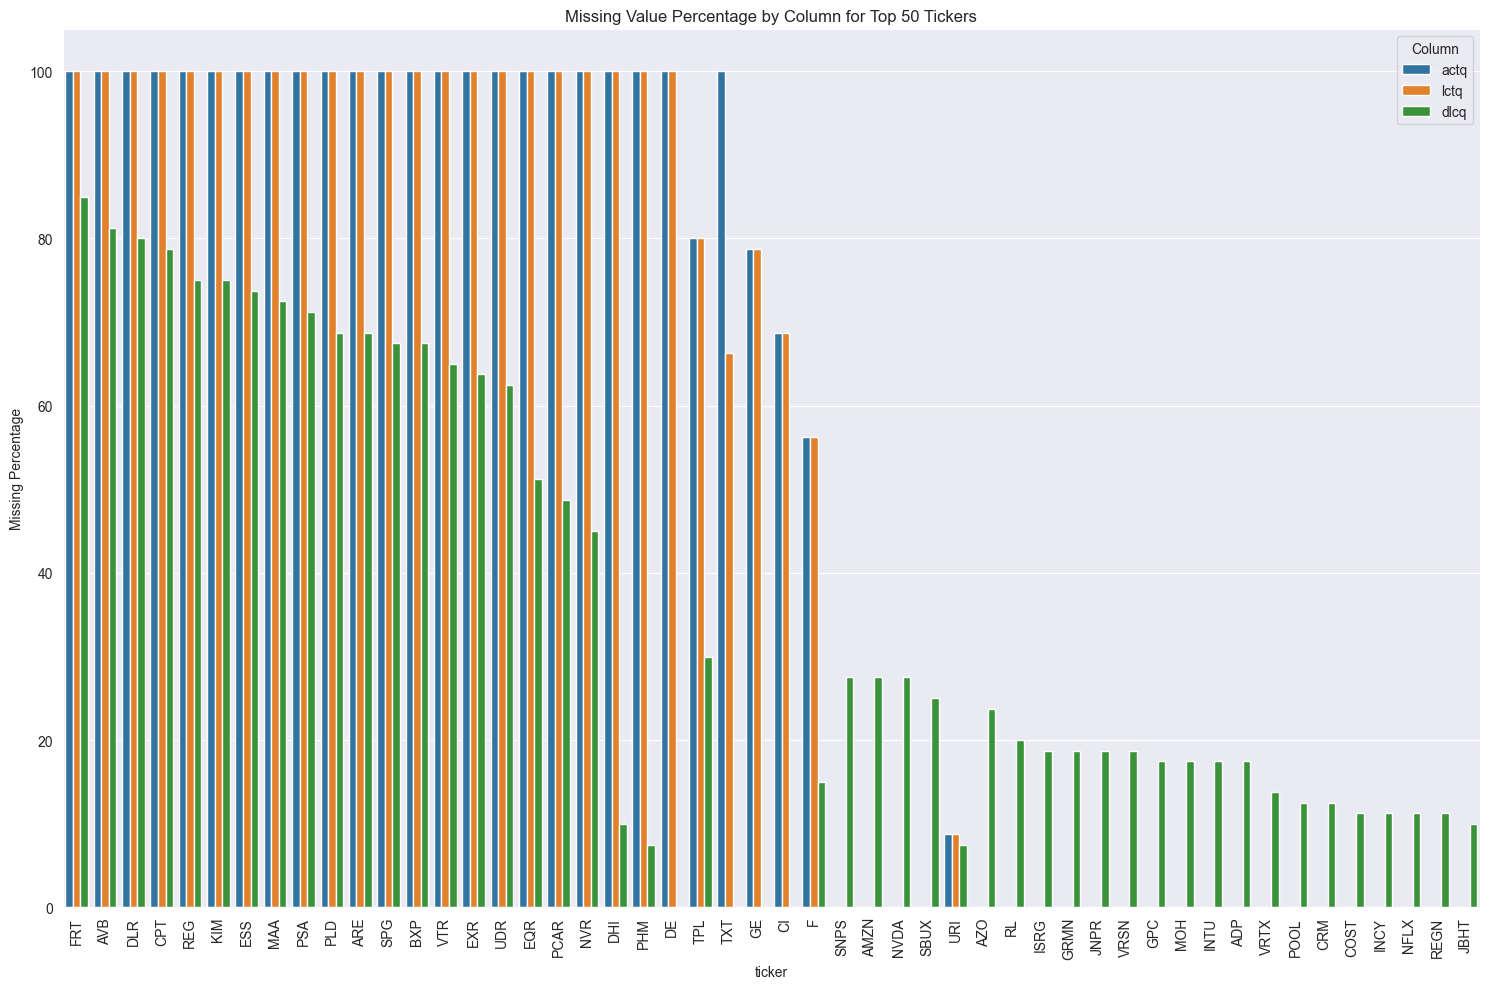

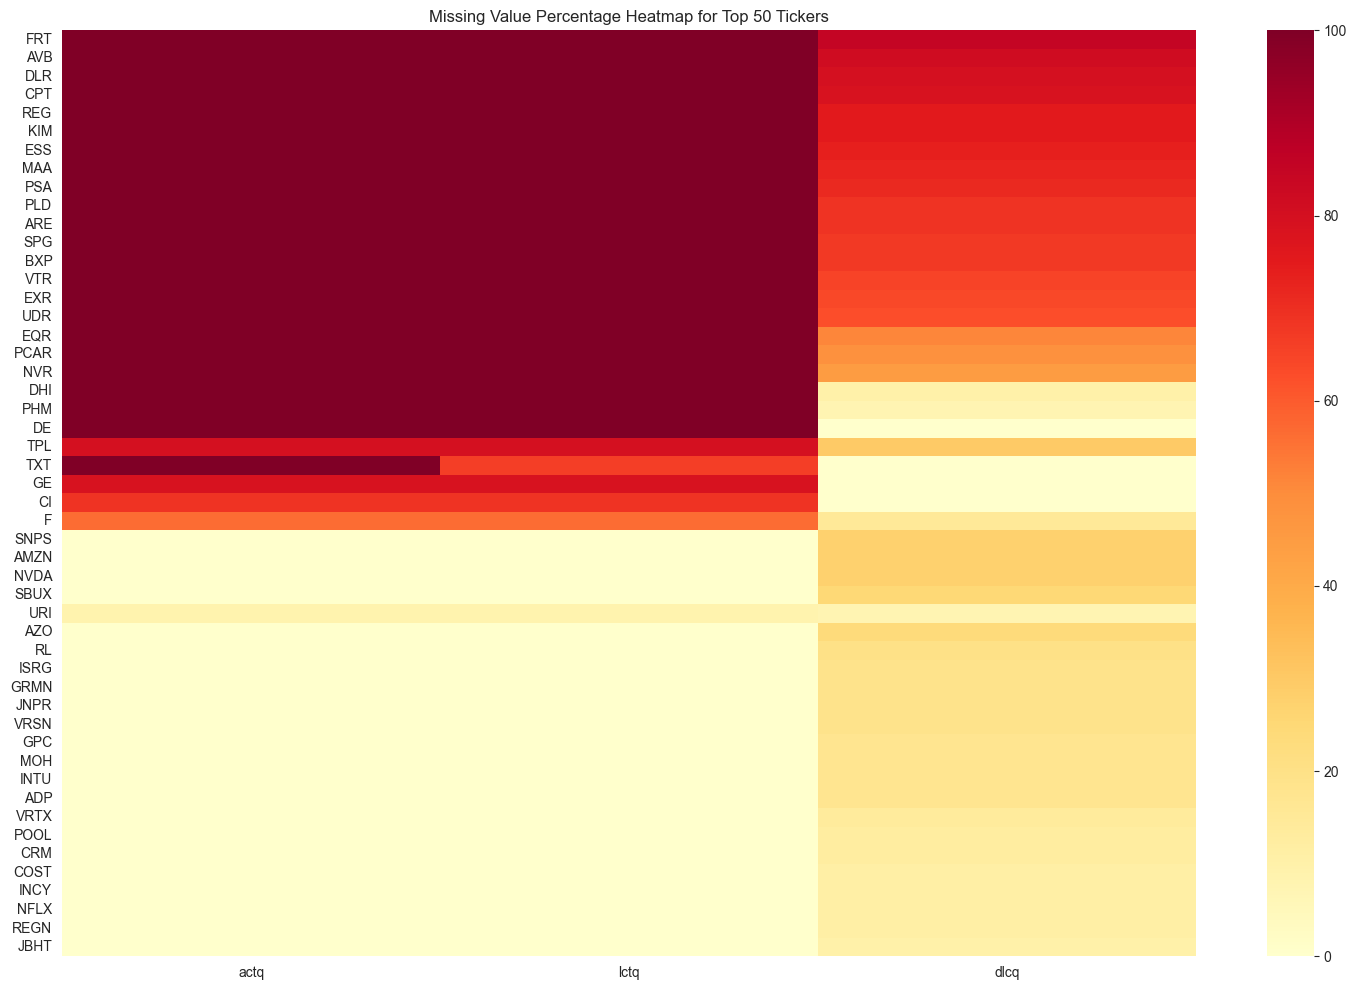

In [63]:
def analyze_missing_by_ticker(df, columns_to_check):
    """
    Analyze missing values for specified columns by ticker
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with financial data
    columns_to_check : list
        List of columns to check for missing values
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with missing value percentage by ticker
    """
    # Create a DataFrame to store results
    missing_by_ticker = pd.DataFrame(index=df['ticker'].unique())
    
    # For each ticker, calculate % of missing values for each column
    for ticker in missing_by_ticker.index:
        ticker_data = df[df['ticker'] == ticker]
        for col in columns_to_check:
            missing_pct = ticker_data[col].isna().mean() * 100
            missing_by_ticker.loc[ticker, col] = missing_pct
    
    # Calculate overall missing percentage across all columns
    missing_by_ticker['overall_missing_pct'] = missing_by_ticker[columns_to_check].mean(axis=1)
    
    # Sort by overall missing percentage
    missing_by_ticker = missing_by_ticker.sort_values('overall_missing_pct', ascending=False)
    
    return missing_by_ticker

# Define the columns you want to check
liquidity_columns = ['actq', 'lctq', 'dlcq']  # Current assets, Current liabilities, Inventory, Cash

# Run the analysis
liquidity_missing = analyze_missing_by_ticker(fundamentalsdf, liquidity_columns)

# Print top 10 tickers with most missing values
print("Top 10 tickers with most missing liquidity data:")
print(liquidity_missing.head(10))

# Count tickers with more than 50% missing values in liquidity columns
high_missing = liquidity_missing[liquidity_missing['overall_missing_pct'] > 50]
print(f"\n{len(high_missing)} tickers have >50% missing values in liquidity columns")

# Plot top 50 tickers with most missing values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
top_50_missing = liquidity_missing.head(50)

# Reset index and make sure the index is properly named
top_50_missing_reset = top_50_missing.reset_index()
top_50_missing_reset = top_50_missing_reset.rename(columns={'index': 'ticker'})

# Melt the DataFrame to create a format suitable for a grouped bar chart
melted = pd.melt(top_50_missing_reset, 
                id_vars=['ticker'], 
                value_vars=liquidity_columns,
                var_name='Column', 
                value_name='Missing Percentage')

# Create the grouped bar chart
sns.barplot(x='ticker', y='Missing Percentage', hue='Column', data=melted)
plt.xticks(rotation=90)
plt.title('Missing Value Percentage by Column for Top 50 Tickers')
plt.tight_layout()
# plt.savefig('missing_by_ticker.png')
plt.show()

# Create a heatmap for a different visualization
plt.figure(figsize=(15, 10))
sns.heatmap(top_50_missing[liquidity_columns], cmap="YlOrRd", annot=False)
plt.title('Missing Value Percentage Heatmap for Top 50 Tickers')
plt.tight_layout()
# plt.savefig('missing_heatmap.png')
plt.show()



In [65]:
def combine_exclusion_lists(tickers_to_exclude, high_missing_tickers, fields_to_exclude):
    """
    Combine ticker exclusion lists from different analyses and return a consolidated list
    of tickers and fields to exclude.
    
    Parameters:
    -----------
    tickers_to_exclude : list
        List of tickers to exclude based on overall missing data threshold (e.g., >30%)
    high_missing_tickers : list or pandas.Index
        List of tickers with high missing data for specific factors from analyze_missing_by_ticker
    fields_to_exclude : list
        List of fields to exclude based on missing data threshold (e.g., >25%)
    
    Returns:
    --------
    tuple
        (final_tickers_to_exclude, fields_to_exclude, stats)
        where stats is a dictionary with summary statistics
    """
    # Convert to sets for efficient operations
    set1 = set(tickers_to_exclude)
    set2 = set(high_missing_tickers)
    
    # Find overlap and unique tickers in each list
    overlap_tickers = set1.intersection(set2)
    unique_to_set1 = set1 - set2
    unique_to_set2 = set2 - set1
    
    # Combine all tickers to exclude
    final_tickers_to_exclude = list(set1.union(set2))
    
    # Create stats dictionary
    stats = {
        'total_tickers_excluded': len(final_tickers_to_exclude),
        'from_overall_threshold_only': len(unique_to_set1),
        'from_specific_factors_only': len(unique_to_set2),
        'in_both_lists': len(overlap_tickers),
        'fields_excluded': len(fields_to_exclude)
    }
    
    # Sort the lists for readability
    final_tickers_to_exclude = sorted(final_tickers_to_exclude)
    fields_to_exclude = sorted(fields_to_exclude)
    
    # Print summary statistics
    print(f"Overall threshold-only tickers {unique_to_set1}")
    print(f"Total tickers to exclude: {stats['total_tickers_excluded']}")
    print(f"   - {stats['from_overall_threshold_only']} tickers excluded based on overall threshold only")
    print(f"   - {stats['from_specific_factors_only']} tickers excluded based on specific factors only")
    print(f"   - {stats['in_both_lists']} tickers excluded based on both criteria")
    print(f"Total fields to exclude: {stats['fields_excluded']}")
    
    return final_tickers_to_exclude, fields_to_exclude, stats

In [66]:
# Combine the exclusion lists
high_missing_tickers = high_missing.index.tolist()
final_tickers_to_exclude, final_fields_to_exclude, stats = combine_exclusion_lists(
    tickers_to_exclude, 
    high_missing_tickers,
    fields_to_exclude
)

# Create a clean dataframe without problematic tickers and fields
clean_df = fundamentalsdf[~fundamentalsdf['ticker'].isin(final_tickers_to_exclude)].copy()
clean_df = clean_df.drop(columns=final_fields_to_exclude)

print(f"Original DataFrame shape: {fundamentalsdf.shape}")
print(f"Original number of tickers: {len(fundamentalsdf['ticker'].unique())}")
print(f"Clean DataFrame shape: {clean_df.shape}")
print(f"Removed {fundamentalsdf.shape[0] - clean_df.shape[0]} rows and {fundamentalsdf.shape[1] - clean_df.shape[1]} columns")
print(f"Remaining number of tickers: {len(clean_df['ticker'].unique())}")

Overall threshold-only tickers set()
Total tickers to exclude: 25
   - 0 tickers excluded based on overall threshold only
   - 4 tickers excluded based on specific factors only
   - 21 tickers excluded based on both criteria
Total fields to exclude: 1
Original DataFrame shape: (23156, 29)
Original number of tickers: 290
Clean DataFrame shape: (21156, 28)
Removed 2000 rows and 1 columns
Remaining number of tickers: 265


In [67]:
print(clean_df.shape)
# print(high_missing_tickers)

(21156, 28)


In [68]:
# Check how many rows have ticker LBTYA before removal
lbtya_count = len(clean_df[clean_df['ticker'] == 'LBTYA'])
print(f"Found {lbtya_count} rows with ticker LBTYA")

# Remove ticker LBTYA from the DataFrame
clean_df = clean_df[clean_df['ticker'] != 'LBTYA'].copy()

# Verify ticker was removed
if 'LBTYA' not in clean_df['ticker'].unique():
    print("Successfully removed ticker LBTYA")
else:
    print("Warning: LBTYA still exists in the DataFrame")

# Check new DataFrame shape
print(f"New DataFrame shape: {clean_df.shape}")

Found 36 rows with ticker LBTYA
Successfully removed ticker LBTYA
New DataFrame shape: (21120, 28)


In [71]:
# 1. Adjust prices
adjusted_stock_data = DataPreprocessor.adjust_prices(filtered_df)

In [72]:
stocks_factors = DataPreprocessor.append_factors_to_stocks(adjusted_stock_data, fama_french)
print(stocks_factors.shape)
print(stocks_factors.columns.tolist())
print(stocks_factors.head())

(69840, 24)
['permno', 'date', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'industry', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd']
      permno       date ticker    prc  price_unadj       ret      retx  \
222    87432 2005-01-31      A  22.11        22.11 -0.082573 -0.082573   
589    87432 2005-02-28      A   24.0         24.0  0.085482  0.085482   
890    87432 2005-03-31      A   22.2         22.2    -0.075    -0.075   
1283   87432 2005-04-29      A  20.75        20.75 -0.065315 -0.065315   
1615   87432 2005-05-31      A  24.01        24.01  0.157108  0.157108   

           vol    shrout  price_adjustment_factor  ...  \
222   504683.0  491098.0                 1.464715  ...   
589   513677.0  491000.0                 1.464715  ...   
890   557250.0  491164.0                 1.464715  ...   
1283  545919.0  49

In [73]:
clean_df_tra = DataPreprocessor.expand_quarterly_to_monthly(clean_df)

Processing 264 unique tickers


/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:426: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_months = ticker_months.sort_values('date').fillna(method='ffill')
/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:429: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_months = ticker_months.fillna(method='bfill')
/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:426: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_months = ticker_months.sort_values('date').fillna(method='ffill')
/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:429: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

Top 5 columns with most missing values:
invtq    240
dtype: int64
Date range: 2005-01-01 to 2024-12-01


In [74]:
print(clean_df_tra.shape)
print(clean_df_tra.columns.tolist())
print(clean_df_tra.head())
print(f"null values: {clean_df_tra.isnull().sum()}")
print(clean_df_tra['date'].min())
print(clean_df_tra['date'].max())
print(clean_df_tra['gvkey'].nunique())
print(clean_df_tra['ticker'].nunique())

(63360, 30)
['date', 'ticker', 'gvkey', 'permno', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date', 'year_month']
        date ticker   gvkey   permno  fyearq     atq     ltq    seqq   ibq  \
0 2005-01-01      A  126554  87432.0  2005.0  7150.0  3382.0  3768.0  51.0   
1 2005-02-01      A  126554  87432.0  2005.0  7150.0  3382.0  3768.0  51.0   
2 2005-03-01      A  126554  87432.0  2005.0  7150.0  3382.0  3768.0  51.0   
3 2005-04-01      A  126554  87432.0  2005.0  7150.0  3382.0  3768.0  51.0   
4 2005-05-01      A  126554  87432.0  2005.0  7150.0  3382.0  3768.0  51.0   

   cshoq  ...  dvpsxq    actq    lctq  txtq   dpq   invtq  pstkq  ajexq  \
0  491.0  ...     0.0  4649.0  1771.0  15.0  48.0  1037.0    0.0    1.0   
1  491.0  ...     0.0  4649.0  1771.0  15.0  48.0  1037.0    0.0    1.0   
2  491.0  ...     0.0 

In [75]:
# Check date range
print(f"Date range in expanded data: {clean_df_tra['date'].min()} to {clean_df_tra['date'].max()}")

# Check if you have all months in your target range
target_months = pd.date_range(start='2005-01-01', end='2024-12-31', freq='MS')
existing_months = pd.DatetimeIndex(clean_df_tra['date'].unique())
missing_months = set(target_months) - set(existing_months)

if missing_months:
    print(f"Missing {len(missing_months)} months in the dataset")
    print(f"First few missing months: {sorted(list(missing_months))[:5]}")

Date range in expanded data: 2005-01-01 00:00:00 to 2024-12-01 00:00:00


In [76]:
# Calculate missing values by ticker and month
missing_by_ticker_month = clean_df_tra.groupby(['ticker', 'date']).apply(
    lambda x: x.drop(['ticker', 'date'], axis=1).isna().mean() * 100
)
missing_by_ticker_month = missing_by_ticker_month.reset_index()

# Get the tickers with most missing data
ticker_missing = clean_df_tra.groupby('ticker').apply(
    lambda x: x.drop(['ticker', 'date'], axis=1).isna().mean() * 100
).mean(axis=1).sort_values(ascending=False)

print("\nTickers with most missing values:")
print(ticker_missing.head(10))

# Check missing values by time period
monthly_missing = clean_df_tra.groupby(clean_df_tra['date'].dt.to_period('M')).apply(
    lambda x: x.drop(['date'], axis=1).isna().mean() * 100
).mean(axis=1).sort_values(ascending=False)

print("\nMonths with most missing values:")
print(monthly_missing.head(10))

/var/folders/0n/w0fqhn293kv9bk58b7dwx7xw0000gn/T/ipykernel_24143/494730615.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_ticker_month = clean_df_tra.groupby(['ticker', 'date']).apply(
/var/folders/0n/w0fqhn293kv9bk58b7dwx7xw0000gn/T/ipykernel_24143/494730615.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ticker_missing = clean_df_tra.groupby('ticker').apply(



Tickers with most missing values:
ticker
CHRW    3.571429
ZBRA    0.000000
A       0.000000
AAPL    0.000000
ABT     0.000000
ACN     0.000000
ADBE    0.000000
ADI     0.000000
VRSN    0.000000
TJX     0.000000
dtype: float64

Months with most missing values:
date
2005-01    0.013062
2005-02    0.013062
2005-03    0.013062
2005-04    0.013062
2005-05    0.013062
2005-06    0.013062
2005-07    0.013062
2005-08    0.013062
2005-09    0.013062
2005-10    0.013062
Freq: M, dtype: float64


In [77]:
# Check missing values by column
missing_by_column = clean_df_tra.isna().mean() * 100
print("\nMissing values by column:")
print(missing_by_column.sort_values(ascending=False).head(20))


Missing values by column:
invtq     0.378788
date      0.000000
gvkey     0.000000
permno    0.000000
fyearq    0.000000
ticker    0.000000
ltq       0.000000
seqq      0.000000
ibq       0.000000
cshoq     0.000000
epspxq    0.000000
revtq     0.000000
niq       0.000000
atq       0.000000
cogsq     0.000000
capsq     0.000000
dlttq     0.000000
cheq      0.000000
oiadpq    0.000000
prccq     0.000000
dtype: float64


In [78]:
# Find tickers with incomplete time series
ticker_date_counts = clean_df_tra.groupby('ticker')['date'].nunique()
expected_months = len(pd.date_range(start='2005-01-01', end='2024-12-31', freq='MS'))
incomplete_tickers = ticker_date_counts[ticker_date_counts < expected_months]

print(f"\nTickers with incomplete time series (fewer than {expected_months} months):")
print(incomplete_tickers.sort_values().head(10))


Tickers with incomplete time series (fewer than 240 months):
Series([], Name: date, dtype: int64)


In [79]:
# Remove ticker CHRW from the DataFrame
clean_df_fixed = clean_df_tra[clean_df_tra['ticker'] != 'CHRW'].copy()

# Verify ticker was removed
if 'CHRW' not in clean_df_fixed['ticker'].unique():
    print("Successfully removed ticker CHRW")
else:
    print("Warning: CHRW still exists in the DataFrame")

# Check new DataFrame shape
print(f"New DataFrame shape: {clean_df_fixed.shape}")
# print(clean_df_fixed[clean_df_fixed['ticker'] == 'CHRW'])

Successfully removed ticker CHRW
New DataFrame shape: (63120, 30)


In [80]:
Merged_df = DataPreprocessor.merge_fundamentals_with_stock_data(clean_df_fixed, stocks_factors, merge_on='ticker')


Checking fundamentals data for duplicates before merge:

Checking stock data for duplicates before merge:

Fundamentals tickers: 263
Stock data tickers: 291
Common tickers: 263

Fundamentals has data for 240 months
First month in fundamentals: 2005-01
Last month in fundamentals: 2024-12
Stock data has data for 240 months
First month in stock data: 2005-01
Last month in stock data: 2024-12
Common months between datasets: 240
First common month: 2005-01
Last common month: 2024-12

No duplicates found in the merged data. Good!

Final dataset contains 263 unique tickers across 240 months
First month in merged data: 2005-01
Last month in merged data: 2024-12


In [81]:
print(Merged_df.shape)
print(Merged_df.columns.tolist())
print(Merged_df.head())
print(Merged_df.isnull().sum())
print(Merged_df['date_stock'].min())
print(Merged_df['date_stock'].max())
print(Merged_df['gvkey'].nunique())
print(Merged_df['ticker'].nunique())


(63120, 53)
['permno_stock', 'date_stock', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'industry', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'year_month', 'date_fundamentals', 'gvkey', 'permno_fundamentals', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date']
   permno_stock date_stock ticker    prc  price_unadj       ret      retx  \
0         87432 2005-01-31      A  22.11        22.11 -0.082573 -0.082573   
1         87432 2005-02-28      A   24.0         24.0  0.085482  0.085482   
2         87432 2005-03-31      A   22.2         22.2    -0.075    -0.075   
3         87432 2005-04-29      A  20.75        20.75 -0.065315 -0.065315   
4         8

In [82]:
# 2. Calculate financial ratios
processed_fundamental_data = DataPreprocessor.calculate_financial_ratios(Merged_df)
print(processed_fundamental_data.shape)
print(processed_fundamental_data.columns.tolist())
print(processed_fundamental_data[['date_stock', 'quarter_date']].head())
print(processed_fundamental_data.isnull().sum())
# Get NA counts by column
na_by_column = processed_fundamental_data.isna().sum()
print("\nNA counts by column:")
print(na_by_column)
# Show only columns that have NA values
columns_with_nas = na_by_column[na_by_column > 0]
print("\nColumns with NA values:")
print(columns_with_nas)

(63120, 73)
['permno_stock', 'date_stock', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'industry', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'year_month', 'date_fundamentals', 'gvkey', 'permno_fundamentals', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date', 'debt_equity', 'leverage', 'earnings_yield', 'bp_ratio', 'roa', 'roe', 'operating_margin', 'current_ratio', 'quick_ratio', 'asset_turnover', 'tax_rate', 'nopat', 'invested_capital', 'roic', 'nopat_growth_qoq', 'nopat_growth_yoy', 'invested_capital_growth_qoq', 'invested_capital_growth_yoy', 'revenue_growth_qoq', 'revenue_growth_yoy']
  date_stock quarter_date
0 2005-01-31   2005-01-31
1 2005-0

In [83]:
processed_fundamental_data_ret = DataPreprocessor.fill_returns_and_calculate_excess(processed_fundamental_data)
print(processed_fundamental_data_ret.isna().sum().sum())
print(processed_fundamental_data_ret.isna().sum())

# Get NA counts by column
na_by_column = processed_fundamental_data_ret.isna().sum()
print("\nNA counts by column:")
print(na_by_column)
# Show only columns that have NA values
columns_with_nas = na_by_column[na_by_column > 0]
print("\nColumns with NA values:")
print(columns_with_nas)

20914
permno_stock                      0
date_stock                        0
ticker                            0
prc                               0
price_unadj                       0
                               ... 
invested_capital_growth_qoq    1765
invested_capital_growth_yoy    4132
revenue_growth_qoq             1765
revenue_growth_yoy             4132
excess_ret                        0
Length: 74, dtype: int64

NA counts by column:
permno_stock                      0
date_stock                        0
ticker                            0
prc                               0
price_unadj                       0
                               ... 
invested_capital_growth_qoq    1765
invested_capital_growth_yoy    4132
revenue_growth_qoq             1765
revenue_growth_yoy             4132
excess_ret                        0
Length: 74, dtype: int64

Columns with NA values:
nopat_growth_qoq               3401
nopat_growth_yoy               5719
invested_capital_growth_qoq    17

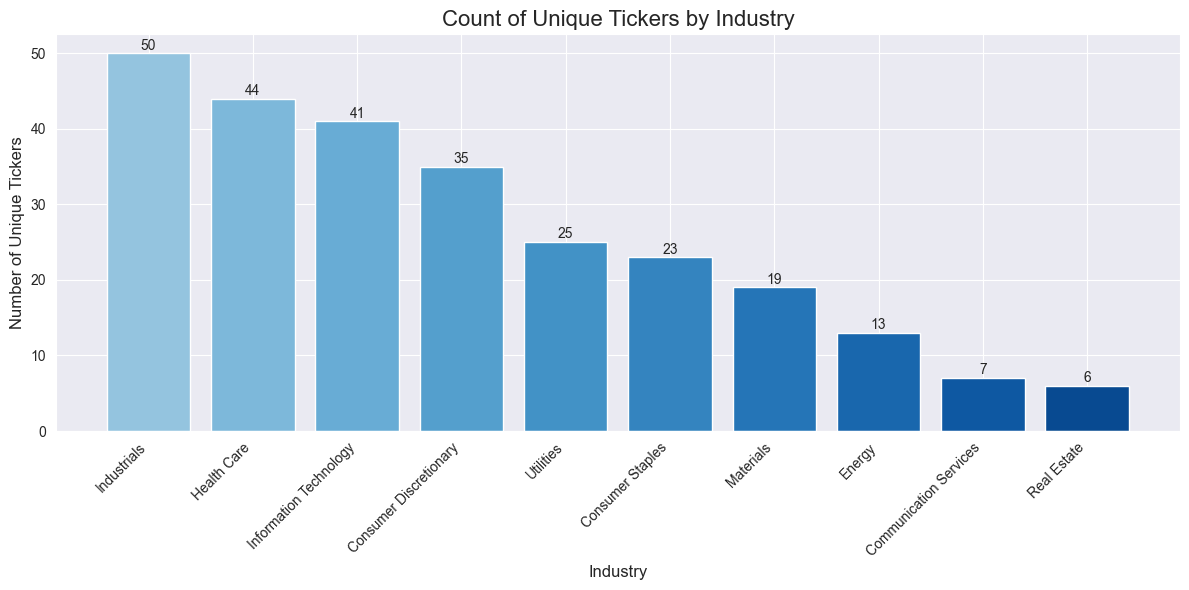

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique tickers grouped by industry
# First, create a dataframe with just unique ticker-industry pairs
unique_ticker_industry = processed_fundamental_data_ret[['ticker', 'industry']].drop_duplicates()

# Then count tickers per industry
industry_counts = unique_ticker_industry['industry'].value_counts()

# Create a color map with different shades of blue
blues = plt.cm.Blues(np.linspace(0.4, 0.9, len(industry_counts)))

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(industry_counts.index, industry_counts.values, color=blues)

# Add labels and title
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Unique Tickers', fontsize=12)
plt.title('Count of Unique Tickers by Industry', fontsize=16)

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}', ha='center', va='bottom')

# Adjust layout to make room for labels
plt.savefig('industry_counts.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

# Show the chart
plt.show()

In [85]:
print(processed_fundamental_data.head())

   permno_stock date_stock ticker    prc  price_unadj       ret      retx  \
0         87432 2005-01-31      A  22.11        22.11 -0.082573 -0.082573   
1         87432 2005-02-28      A   24.0         24.0  0.085482  0.085482   
2         87432 2005-03-31      A   22.2         22.2    -0.075    -0.075   
3         87432 2005-04-29      A  20.75        20.75 -0.065315 -0.065315   
4         87432 2005-05-31      A  24.01        24.01  0.157108  0.157108   

        vol    shrout  price_adjustment_factor  ...  tax_rate      nopat  \
0  504683.0  491098.0                 1.464715  ...  0.294118  31.058824   
1  513677.0  491000.0                 1.464715  ...  0.294118  31.058824   
2  557250.0  491164.0                 1.464715  ...  0.294118  31.058824   
3  545919.0  491164.0                 1.464715  ...  0.294118  31.058824   
4  482805.0  491000.0                 1.464715  ...  0.294118  31.058824   

   invested_capital      roic  nopat_growth_qoq  nopat_growth_yoy  \
0          

In [86]:
# 5. Calculate technical indicators
fully_processed_data = DataPreprocessor.calculate_technical_indicators(processed_fundamental_data_ret)

/Users/oliverbeck/Desktop/Thesis1/ETL_scripts/preprocessor.py:698: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, -0.06151062867480772, 0.0004166666666667318, 0.036936936936937004, 0.26457831325301195, 0.3394418992086625, 0.42267593397046044, 0.21989329268292668, 0.10883084577114444, 0.01648854961832069, 0.05935645110902854, 0.00953449242849147, 0.12796635626314212, 0.1329991153052199, -0.03083333333333338, -0.1595206391478029, -0.2597605413846955, -0.07824591573516781, 0.035804816223067304, 0.25175808720112514, 0.0497874722506817, 0.130400207675758, -0.04688710102247429, -0.0028266331658292065, -0.03328550932568153, 0.07406249999999992, 0.20220472440944892, 0.14099139210448208, 0.10997963340122197, -0.04637149593921941, -0.04058272632674287, -0.03407601572739183, 0.039285714285714146, -0.003796095444685399, -0.08113975576662147, -0.1908538197197991, -0.18807838867719118, -0.10779681039

In [87]:
print(fully_processed_data.shape)
print(processed_fundamental_data_ret.shape)
print(fully_processed_data.columns.tolist())
print(fully_processed_data.head())
print(fully_processed_data.isnull().sum())
print(fully_processed_data['date_stock'].min())
print(fully_processed_data['date_stock'].max())
print(fully_processed_data['gvkey'].nunique())
print(fully_processed_data['ticker'].nunique())

(63120, 87)
(63120, 74)
['permno_stock', 'date_stock', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'industry', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'year_month', 'date_fundamentals', 'gvkey', 'permno_fundamentals', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date', 'debt_equity', 'leverage', 'earnings_yield', 'bp_ratio', 'roa', 'roe', 'operating_margin', 'current_ratio', 'quick_ratio', 'asset_turnover', 'tax_rate', 'nopat', 'invested_capital', 'roic', 'nopat_growth_qoq', 'nopat_growth_yoy', 'invested_capital_growth_qoq', 'invested_capital_growth_yoy', 'revenue_growth_qoq', 'revenue_growth_yoy', 'excess_ret', 'sma_6m', 'sma_12m', 'sma_24m', 'v

In [91]:
print(fully_processed_data['year_month'])
print(macro['year_month'])

0        2005-01
1        2005-02
2        2005-03
3        2005-04
4        2005-05
          ...   
63115    2024-08
63116    2024-09
63117    2024-10
63118    2024-11
63119    2024-12
Name: year_month, Length: 63120, dtype: object
0     2005-01-31
1     2005-02-28
2     2005-03-31
3     2005-04-30
4     2005-05-31
         ...    
235   2024-08-31
236   2024-09-30
237   2024-10-31
238   2024-11-30
239   2024-12-31
Name: year_month, Length: 240, dtype: datetime64[ns]


In [98]:
macro = macro.drop(columns='inflation_yoy')
print(macro.shape)
print(macro.columns.tolist())
print(macro.head())
print(f"null values: {macro.isnull().sum()}")
print(macro['date'].min())
print(macro['date'].max())
#print(macro['gvkey'].nunique())
#print(macro['ticker'].nunique())

(240, 17)
['date', 'tb3m_rate', 'tb10y_rate', 'fed_funds_rate', 'gs2_rate', 'aaa_rate', 'baa_rate', 'term_spread', 'credit_spread', 'gdp_monthly', 'gdp_quarterly', 'cpi', 'unemployment_rate', 'gdp_growth_yoy', 'gdp_growth_qoq', 'unemployment_change', 'year_month']
         date  tb3m_rate  tb10y_rate  fed_funds_rate  gs2_rate  aaa_rate  \
0  2005-01-31       2.33        4.22            2.28      3.22      5.36   
1  2005-02-28       2.54        4.17             2.5      3.38       5.2   
2  2005-03-31       2.74         4.5            2.63      3.73       5.4   
3  2005-04-30       2.78        4.34            2.79      3.65      5.33   
4  2005-05-31       2.84        4.14             3.0      3.64      5.15   

   baa_rate  term_spread  credit_spread  gdp_monthly  gdp_quarterly     cpi  \
0      6.02         1.89           0.66   15987.9575      15844.727  3.3658   
1      5.82         1.63           0.62   15987.9575      15844.727  3.3658   
2      6.06         1.76           0.66  

In [99]:
def append_macros_to_stocks(stocks_df, macros_df, date_column='year_month'):
        """
        Appends factor data to stock data based on matching year and month.
        
        Parameters:
        -----------
        stocks_df : pandas.DataFrame
            DataFrame containing stock data. Can be a single stock or multiple stocks.
            Must have a datetime column (specified by date_column parameter).
        
        factors_df : pandas.DataFrame
            DataFrame containing factor data.
            Must have the same datetime column as stocks_df.
        
        date_column : str, default='date'
            The name of the column containing the date information in both DataFrames.
            
        Returns:
        --------
        pandas.DataFrame
            A copy of the stocks_df with factor columns appended.
        """
        # Convert date columns to datetime if they aren't already
        # if not pd.api.types.is_datetime64_dtype(stocks_df[date_column]):
        #     stocks_df = stocks_df.copy()
        #     stocks_df[date_column] = pd.to_datetime(stocks_df[date_column])
        
        # if not pd.api.types.is_datetime64_dtype(factors_df[date_column]):
        #     factors_df = factors_df.copy()
        #     factors_df[date_column] = pd.to_datetime(factors_df[date_column])
        
        # Create year-month columns for matching
        macros_df['year_month'] = macros_df[date_column].dt.strftime('%Y-%m')
        
        # Get list of factor columns to append (all columns except date and year_month)
        factor_columns = [col for col in macros_df.columns 
                        if col not in [date_column, 'year_month']]
        
        # Create a mapping dictionary from year_month to factor values
        factor_dict = {}
        for col in factor_columns:
            # Create a dict mapping year_month to the factor value
            temp_dict = dict(zip(macros_df['year_month'], macros_df[col]))
            factor_dict[col] = temp_dict
        
        # Create result dataframe
        result_df = stocks_df.copy()
        
        # Add each factor column
        for col in factor_columns:
            result_df[col] = result_df['year_month'].map(factor_dict[col])
        
        # Drop the temporary year_month column
        result_df = result_df.drop(columns=['year_month'])
        
        return result_df

In [100]:
final_data = append_macros_to_stocks(fully_processed_data, macro, date_column='year_month')
print(final_data.shape)
print(final_data.columns.tolist())
print(final_data.head())
print(final_data.isnull().sum())

AttributeError: Can only use .dt accessor with datetimelike values

In [95]:
final_datax = pd.get_dummies(final_data, columns=['industry'], drop_first=False) 
print(final_datax.columns.tolist())

['permno_stock', 'date_stock', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'date_fundamentals', 'gvkey', 'permno_fundamentals', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date', 'debt_equity', 'leverage', 'earnings_yield', 'bp_ratio', 'roa', 'roe', 'operating_margin', 'current_ratio', 'quick_ratio', 'asset_turnover', 'tax_rate', 'nopat', 'invested_capital', 'roic', 'nopat_growth_qoq', 'nopat_growth_yoy', 'invested_capital_growth_qoq', 'invested_capital_growth_yoy', 'revenue_growth_qoq', 'revenue_growth_yoy', 'excess_ret', 'sma_6m', 'sma_12m', 'sma_24m', 'volatility_12m', 'volatility_24m', 'rsi_6m', 'ema_3

In [101]:
final_datax = final_datax.drop(columns='inflation_yoy')
print(final_datax.columns.tolist())

['permno_stock', 'date_stock', 'ticker', 'prc', 'price_unadj', 'ret', 'retx', 'vol', 'shrout', 'price_adjustment_factor', 'shares_adjustment_factor', 'price_adjusted', 'volume_adjusted', 'shares_outstanding_adjusted', 'market_cap', 'cum_ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'date_fundamentals', 'gvkey', 'permno_fundamentals', 'fyearq', 'atq', 'ltq', 'seqq', 'ibq', 'cshoq', 'epspxq', 'revtq', 'niq', 'cogsq', 'capsq', 'cheq', 'dlttq', 'dlcq', 'oiadpq', 'prccq', 'dvpsxq', 'actq', 'lctq', 'txtq', 'dpq', 'invtq', 'pstkq', 'ajexq', 'quarter_date', 'debt_equity', 'leverage', 'earnings_yield', 'bp_ratio', 'roa', 'roe', 'operating_margin', 'current_ratio', 'quick_ratio', 'asset_turnover', 'tax_rate', 'nopat', 'invested_capital', 'roic', 'nopat_growth_qoq', 'nopat_growth_yoy', 'invested_capital_growth_qoq', 'invested_capital_growth_yoy', 'revenue_growth_qoq', 'revenue_growth_yoy', 'excess_ret', 'sma_6m', 'sma_12m', 'sma_24m', 'volatility_12m', 'volatility_24m', 'rsi_6m', 'ema_3

In [103]:
final_datax.shape

(63120, 111)

In [102]:
final_datax.to_csv('final_datax.csv', index=False)

In [104]:
print(final_datax[['sma_6', 'sma_12', 'ema_3', 'ema_9']])

KeyError: "None of [Index(['sma_6', 'sma_12', 'ema_3', 'ema_9'], dtype='object')] are in the [columns]"

In [97]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_stocks_paginated(adjusted_stock_data, tickers_per_page=10, page=0):
    """
    Plot stock data 10 tickers at a time.
    
    Parameters:
    -----------
    adjusted_stock_data : pandas DataFrame
        DataFrame containing stock data
    tickers_per_page : int
        Number of tickers to display per page (default: 10)
    page : int
        Which page of tickers to display (starting from 0)
    
    Returns:
    --------
    next_page : int
        The next page number (for convenience in iterating)
    """
    # Get all unique tickers and sort them
    all_tickers = sorted(adjusted_stock_data['ticker'].unique())
    
    # Calculate total number of pages
    total_pages = int(np.ceil(len(all_tickers) / tickers_per_page))
    
    # Get tickers for the current page
    start_idx = page * tickers_per_page
    end_idx = min(start_idx + tickers_per_page, len(all_tickers))
    page_tickers = all_tickers[start_idx:end_idx]
    
    # Create visualization with adjusted prices
    plt.figure(figsize=(12, 6))
    
    for ticker in page_tickers:
        ticker_data = adjusted_stock_data[adjusted_stock_data['ticker'] == ticker]
        plt.plot(ticker_data['date'], ticker_data['price_adjusted'], label=ticker)
    
    plt.title(f'Adjusted Stock Prices Over Time (Page {page+1}/{total_pages})')
    plt.xlabel('Date')
    plt.ylabel('Price (Adjusted)')
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Return the next page (wrapping around if necessary)
    return (page + 1) % total_pages

In [98]:
# Example usage:
current_page = 0

In [ ]:

# First page (tickers 0-9)
current_page = plot_stocks_paginated(adjusted_stock_data, page=current_page)

In [ ]:
def analyze_na_values(data, feature_cols, specific_tickers=None, n_tickers=10, n_rows=5):
    """
    Analyze NA values in your dataset for specific tickers
    
    Args:
        data: DataFrame with your data
        feature_cols: List of feature columns to check for NAs
        specific_tickers: List of specific ticker symbols to analyze (default: None)
        n_tickers: Number of tickers to analyze if specific_tickers not provided (default: 10)
        n_rows: Number of example rows to print for each ticker (default: 5)
        
    Returns:
        DataFrame with NA summary statistics
    """
    import pandas as pd
    import numpy as np
    
    # Get all unique tickers
    all_tickers = data['ticker'].unique()
    
    # Select tickers to analyze
    if specific_tickers is not None:
        # Filter to make sure we only analyze tickers that actually exist in the data
        tickers_to_analyze = [ticker for ticker in specific_tickers if ticker in all_tickers]
        if len(tickers_to_analyze) == 0:
            print("None of the specified tickers found in the dataset.")
            return pd.DataFrame()
        print(f"Analyzing NA values for {len(tickers_to_analyze)} specified tickers: {', '.join(tickers_to_analyze)}")
    else:
        # Use the first n_tickers if no specific tickers provided
        tickers_to_analyze = all_tickers[:n_tickers]
        print(f"Analyzing NA values across {len(tickers_to_analyze)} tickers")
    
    # Store results
    results = []
    
    # Analyze each ticker
    for ticker in tickers_to_analyze:
        print(f"\n--- Analyzing ticker: {ticker} ---")
        
        # Get data for this ticker
        ticker_data = data[data['ticker'] == ticker].copy().sort_values('date')
        
        if len(ticker_data) == 0:
            print(f"No data found for ticker {ticker}")
            continue
            
        # Count NAs for each feature
        na_counts = ticker_data[feature_cols].isna().sum()
        na_percents = (na_counts / len(ticker_data) * 100).round(2)
        
        # Print features with NAs
        print(f"Total rows for {ticker}: {len(ticker_data)}")
        
        features_with_nas = na_counts[na_counts > 0]
        if len(features_with_nas) > 0:
            print(f"Features with NAs ({len(features_with_nas)} out of {len(feature_cols)}):")
            for feature, count in features_with_nas.items():
                print(f"  - {feature}: {count} NAs ({na_percents[feature]}%)")
        else:
            print("No features with NAs found")
            
        # Check for patterns: Are NAs at the beginning (common for time series)?
        if len(features_with_nas) > 0:
            # Find rows with any NA in feature columns
            rows_with_na = ticker_data[ticker_data[feature_cols].isna().any(axis=1)]
            
            # Print example rows with NAs
            if len(rows_with_na) > 0:
                print(f"\nExample rows with NAs (showing {min(n_rows, len(rows_with_na))} out of {len(rows_with_na)}):")
                for idx, row in rows_with_na.head(n_rows).iterrows():
                    na_features = [col for col in feature_cols if pd.isna(row[col])]
                    print(f"  Row with date {row['date']}: {', '.join(na_features)} have NA values")
                
                # Check if NAs are at the beginning (typical for calculated features)
                first_non_na_idx = ticker_data[~ticker_data[feature_cols].isna().any(axis=1)].index.min()
                if first_non_na_idx is not pd.NaT and first_non_na_idx > ticker_data.index.min():
                    first_complete_date = ticker_data.loc[first_non_na_idx, 'date']
                    na_period = ticker_data[ticker_data.index < first_non_na_idx].shape[0]
                    print(f"\n  First {na_period} rows have NAs (up to {first_complete_date})")
                    print(f"  Complete data starts from {first_complete_date}")
        
        # Add summary stats to results
        for feature in feature_cols:
            results.append({
                'ticker': ticker,
                'feature': feature,
                'na_count': na_counts[feature],
                'na_percent': na_percents[feature],
                'total_rows': len(ticker_data)
            })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results)
    
    # Print overall summary
    print("\n=== OVERALL SUMMARY ===")
    print(f"Analyzed {len(tickers_to_analyze)} tickers")
    
    # Get features most likely to have NAs
    feature_na_counts = summary_df.groupby('feature')['na_count'].sum().sort_values(ascending=False)
    feature_ticker_counts = summary_df[summary_df['na_count'] > 0].groupby('feature')['ticker'].nunique().sort_values(ascending=False)
    
    # Print top features with NAs
    features_with_nas = feature_ticker_counts[feature_ticker_counts > 0]
    if len(features_with_nas) > 0:
        print("\nFeatures most likely to have NAs (across tickers):")
        for feature, count in features_with_nas.items():
            print(f"  - {feature}: affects {count} of {len(tickers_to_analyze)} analyzed tickers")
    
    return summary_df

# To use this function in your main code, add this before your model training:
def run_na_analysis_before_training(data, feature_cols, specific_tickers=None, n_tickers=10):
    print("\n========== NA VALUE ANALYSIS ==========")
    summary = analyze_na_values(data, feature_cols, specific_tickers=specific_tickers, n_tickers=n_tickers)
    
    # Get median number of rows with complete data per ticker
    base_features = ['mktrf', 'smb', 'hml', 'rmw', 'cma']  # Your base features that should be complete
    calc_features = [f for f in feature_cols if f not in base_features]  # Your calculated features
    
    # Calculate rows with complete data (no NAs)
    n_tickers_analyzed = len(summary['ticker'].unique())
    rows_with_nas = summary[summary['feature'].isin(calc_features)].groupby('ticker')['na_count'].mean()
    total_rows = summary.groupby('ticker')['total_rows'].first()
    complete_rows = total_rows - rows_with_nas
    
    # Print statistics about row counts
    print("\nRows with complete data (no NAs in any features):")
    if len(complete_rows) > 0:
        print(f"  Min: {complete_rows.min()}")
        print(f"  Median: {complete_rows.median()}")
        print(f"  Mean: {complete_rows.mean():.2f}")
        print(f"  Max: {complete_rows.max()}")
    
    # Recommend minimum window size based on complete data
    if len(complete_rows) > 0:
        recommended_min_window = int(complete_rows.median() * 0.8)  # 80% of median complete rows
        print(f"\nRecommended minimum window size: {recommended_min_window}")
        print(f"This would allow you to use approximately 80% of tickers with complete data")
    
    print("=========================================\n")
    return summary


if __name__ == "__main__":
    # Base features and additional features
    base_features = ['mktrf', 'smb', 'hml', 'rmw', 'cma']  # Fama-French 5 factors
    
    # Your calculated features with potential NAs at the beginning
    additional_features = [
        'umd', 'debt_equity', 'leverage', 'earnings_yield', 'bp_ratio', 'roa', 'roe', 
        'operating_margin', 'current_ratio', 'quick_ratio', 'asset_turnover', 'roic',
        'nopat_growth_qoq', 'nopat_growth_yoy', 'invested_capital_growth_qoq', 'invested_capital_growth_yoy',
        'revenue_growth_qoq', 'revenue_growth_yoy'
    ]
    
    # All features together
    all_features = additional_features
    
    # Analyze specific tickers you're interested in
    specific_tickers = ['AMZN', 'AOS', 'COP']
    
    # Run NA analysis for specific tickers
    na_summary = run_na_analysis_before_training(
        data=df,  # Your dataframe
        feature_cols=all_features,
        specific_tickers=specific_tickers  # Pass specific tickers to analyze
    )    